In [1]:
import pandas as pd, matplotlib.pyplot as plt, re
from sklearn.preprocessing import LabelEncoder

FILE_NAME = 'transactions.txt'
df = pd.read_json(FILE_NAME, lines=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   accountNumber             786363 non-null  int64  
 1   customerId                786363 non-null  int64  
 2   creditLimit               786363 non-null  int64  
 3   availableMoney            786363 non-null  float64
 4   transactionDateTime       786363 non-null  object 
 5   transactionAmount         786363 non-null  float64
 6   merchantName              786363 non-null  object 
 7   acqCountry                786363 non-null  object 
 8   merchantCountryCode       786363 non-null  object 
 9   posEntryMode              786363 non-null  object 
 10  posConditionCode          786363 non-null  object 
 11  merchantCategoryCode      786363 non-null  object 
 12  currentExpDate            786363 non-null  object 
 13  accountOpenDate           786363 non-null  o

#### There are no NA values in the dataset that we need to impute/account for

In [2]:
df.isna().sum()

accountNumber               0
customerId                  0
creditLimit                 0
availableMoney              0
transactionDateTime         0
transactionAmount           0
merchantName                0
acqCountry                  0
merchantCountryCode         0
posEntryMode                0
posConditionCode            0
merchantCategoryCode        0
currentExpDate              0
accountOpenDate             0
dateOfLastAddressChange     0
cardCVV                     0
enteredCVV                  0
cardLast4Digits             0
transactionType             0
echoBuffer                  0
currentBalance              0
merchantCity                0
merchantState               0
merchantZip                 0
cardPresent                 0
posOnPremises               0
recurringAuthInd            0
expirationDateKeyInMatch    0
isFraud                     0
dtype: int64

In [3]:
df.nunique()

accountNumber                 5000
customerId                    5000
creditLimit                     10
availableMoney              521915
transactionDateTime         776637
transactionAmount            66038
merchantName                  2490
acqCountry                       5
merchantCountryCode              5
posEntryMode                     6
posConditionCode                 4
merchantCategoryCode            19
currentExpDate                 165
accountOpenDate               1820
dateOfLastAddressChange       2184
cardCVV                        899
enteredCVV                     976
cardLast4Digits               5245
transactionType                  4
echoBuffer                       1
currentBalance              487318
merchantCity                     1
merchantState                    1
merchantZip                      1
cardPresent                      2
posOnPremises                    1
recurringAuthInd                 1
expirationDateKeyInMatch         2
isFraud             

### Defining the *Levenshtein dissimilarity metric* when there's a cvv-mismatch case

Rather than just binary non-equality, check score of mismatch: a single digit wrong might be just a minor blunder.

In [4]:
import numpy as np
def levenshtein_distance(s1, s2):
    r = len(s1)+1
    c = len(s2)+1
    distance = np.zeros((r,c),dtype = int)

    for i in range(1, r):
        for k in range(1,c):
            distance[i][0] = i
            distance[0][k] = k
            
    for col in range(1, c):
        for row in range(1, r):
            if s1[row-1]==s2[col-1]:
                cost = 0
            else:
                cost = 2
            distance[row][col] = min(distance[row-1][col] + 1,      # Cost of deletions
                                 distance[row][col-1] + 1,          # Cost of insertions
                                 distance[row-1][col-1] + cost)     # Cost of substitutions
    return distance[row][col] / (len(s1)+len(s2))



### Engineer some time-dependent features and one for anomolous card-entry

In [5]:
def add_time_dependent_features(df, col, include_time_fields=False):
    df[col+'Year'] = df[col].dt.year
    df[col+'Month'] = df[col].dt.month
    df[col+'Day'] = df[col].dt.day
    df[col+'DayOfWeek'] = df[col].dt.weekday
    if include_time_fields:
        df[col+'Hour'] = df[col].dt.hour
        df[col+'Min'] = df[col].dt.minute
    df = df.drop(col, axis=1)
    return df

df['transactionDt'] = pd.to_datetime(df['transactionDateTime'])
add_time_dependent_features(df, 'transactionDt', True)

df['accountOpenDt'] = pd.to_datetime(df['accountOpenDate'])
df = add_time_dependent_features(df, 'accountOpenDt')

df['lastAddressChangeDt'] = pd.to_datetime(df['dateOfLastAddressChange'])
df = add_time_dependent_features(df, 'lastAddressChangeDt')

#df['cvvMismatch'] = df['cardCVV']!=df['enteredCVV']
# Rather than just binary non-equality, check score of mismatch: a single digit wrong might be just a minor blunder
df['cardCVV'] = df['cardCVV'].astype(str)
df['enteredCVV'] = df['enteredCVV'].astype(str)
df['cvvMismatchScore'] = df.apply(lambda x : levenshtein_distance(x.cardCVV, x.enteredCVV), axis=1)

### Remove the features which have just one categorical value

In [115]:
nvalue_counts_df = df.nunique()
columns_to_drop = nvalue_counts_df.index[nvalue_counts_df.values==1]

main_df = df.copy(deep=True)
main_df = main_df.drop(labels=columns_to_drop, axis=1)

### Identifying return transactions that might've occured after disputes

In [116]:
reversals = df[(df['transactionType']=='REVERSAL') & (df['transactionAmount']>0)]
reversals

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,transactionDtMin,accountOpenDtYear,accountOpenDtMonth,accountOpenDtDay,accountOpenDtDayOfWeek,lastAddressChangeDtYear,lastAddressChangeDtMonth,lastAddressChangeDtDay,lastAddressChangeDtDayOfWeek,cvvMismatchScore
39,574788567,574788567,2500,2200.98,2016-05-24T01:38:03,215.13,Convenient Tire,US,US,09,...,38,2015,10,13,1,2015,10,13,1,0.000000
73,574788567,574788567,2500,2432.72,2016-10-07T10:23:57,3.87,Eazy Repair,US,US,05,...,23,2015,10,13,1,2015,10,13,1,0.000000
101,924729945,924729945,50000,49831.43,2016-10-19T14:01:45,168.57,discount.com,US,US,05,...,1,2014,7,25,4,2014,7,25,4,0.333333
133,984504651,984504651,50000,46367.41,2016-01-16T09:53:15,450.74,Planet Fitness #849960,US,US,05,...,53,2015,7,27,0,2015,7,27,0,0.000000
156,984504651,984504651,50000,41909.30,2016-01-25T20:39:15,81.73,AMC #724446,US,US,09,...,39,2015,7,27,0,2015,7,27,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786106,899818521,899818521,2500,968.33,2016-09-29T02:04:32,10.05,cheapfast.com,US,US,02,...,4,2013,6,15,5,2013,6,15,5,0.000000
786120,638498773,638498773,10000,9798.21,2016-01-01T19:48:03,201.79,KFC #928167,US,US,05,...,48,2014,11,17,0,2014,11,17,0,0.000000
786219,638498773,638498773,10000,5331.33,2016-11-03T04:23:26,86.14,Dunkin' Donuts #396342,US,US,05,...,23,2014,11,17,0,2014,11,17,0,0.000000
786225,638498773,638498773,10000,4393.10,2016-11-06T22:54:25,49.39,Shake Shack #118502,US,US,05,...,54,2014,11,17,0,2014,11,17,0,0.000000


*Example of a reversal scenario:*
Customer makes purchase of $215.13, realizes doesn't need item, returns immediately.

In [117]:
transaction_scenario = df[(df['customerId']==574788567) & (df['merchantName']=='Convenient Tire')]
transaction_scenario[['isFraud','transactionType', 'accountNumber','customerId','creditLimit','availableMoney','transactionDateTime','transactionAmount','merchantName','acqCountry','merchantCountryCode']]

,isFraud,transactionType,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode
38,False,PURCHASE,574788567,574788567,2500,2416.11,2016-05-24T01:35:33,215.13,Convenient Tire,US,US
39,False,REVERSAL,574788567,574788567,2500,2200.98,2016-05-24T01:38:03,215.13,Convenient Tire,US,US
69,False,PURCHASE,574788567,574788567,2500,1232.16,2016-09-24T15:26:31,11.27,Convenient Tire,US,US


### Identifying multi-swipe transactions that might've occured accidentally

For the same candidate-key (`accountNumber`,`merchantName`) if we see 2 or more transactions occured with same amount, then it's likely to be a multi-swipe situation that isn't outright fraud.

In [121]:
# SELECT ACC, MERCHANT WHERE ACC NOT IN (SELECT DISTINCT ACC WHERE TRANSACTION_TYPE="REVERSAL")
non_reversals = df[~df['accountNumber'].isin(reversals['accountNumber'].unique())]

agg_df = df.groupby(by=['accountNumber','merchantName'], as_index=False).agg(
    { 'transactionAmount': {'nunique', 'count', 'mean'}, 'transactionDateTime':{'max', 'min'} })
agg_df.columns = ['Account', 'Merchant', 'Avg. Amount Transacted', 'Unique transactions', 'Total transactions', 'Max-Date', 'Min-Date']
agg_df[(agg_df['Unique transactions']==1) & (agg_df['Total transactions']>1)]

,Account,Merchant,Avg. Amount Transacted,Unique transactions,Total transactions,Max-Date,Min-Date


### Describe the numerical columns and plot histograms to view distributions
All numerical-features seem to follow a power-distribution. Ignore the master-data fields like customerId, accountNumber, credit-card details, etc.

In [8]:
main_df.describe()

,accountNumber,customerId,creditLimit,availableMoney,transactionAmount,cardLast4Digits,currentBalance,transactionDtMonth,transactionDtDay,transactionDtDayOfWeek,...,transactionDtMin,accountOpenDtYear,accountOpenDtMonth,accountOpenDtDay,accountOpenDtDayOfWeek,lastAddressChangeDtYear,lastAddressChangeDtMonth,lastAddressChangeDtDay,lastAddressChangeDtDayOfWeek,cvvMismatchScore
count,7.863630e+05,7.863630e+05,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,...,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.00000,786363.000000
mean,5.372326e+08,5.372326e+08,10759.464459,6250.725369,136.985791,4757.417799,4508.739089,6.648343,15.732804,3.002529,...,29.518682,2013.548618,7.043133,15.917197,3.082027,2014.804087,6.286028,15.476674,2.99443,0.003346
std,2.554211e+08,2.554211e+08,11636.174890,8880.783989,147.725569,2996.583810,6457.442068,3.436256,8.780564,1.995858,...,17.325778,1.872314,3.378144,8.752827,1.949832,1.881635,3.373176,8.591262,1.96869,0.037934
min,1.000881e+08,1.000881e+08,250.000000,-1005.630000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,1989.000000,1.000000,1.000000,0.000000,1989.000000,1.000000,1.000000,0.00000,0.000000
25%,3.301333e+08,3.301333e+08,5000.000000,1077.420000,33.650000,2178.000000,689.910000,4.000000,8.000000,1.000000,...,15.000000,2013.000000,4.000000,8.000000,1.000000,2014.000000,3.000000,8.000000,1.00000,0.000000
50%,5.074561e+08,5.074561e+08,7500.000000,3184.860000,87.900000,4733.000000,2451.760000,7.000000,16.000000,3.000000,...,30.000000,2014.000000,7.000000,16.000000,3.000000,2016.000000,6.000000,15.000000,3.00000,0.000000
75%,7.676200e+08,7.676200e+08,15000.000000,7500.000000,191.480000,7338.000000,5291.095000,10.000000,23.000000,5.000000,...,45.000000,2015.000000,10.000000,23.000000,5.000000,2016.000000,9.000000,23.000000,5.00000,0.000000
max,9.993896e+08,9.993896e+08,50000.000000,50000.000000,2011.540000,9998.000000,47498.810000,12.000000,31.000000,6.000000,...,59.000000,2015.000000,12.000000,31.000000,6.000000,2016.000000,12.000000,31.000000,6.00000,1.000000


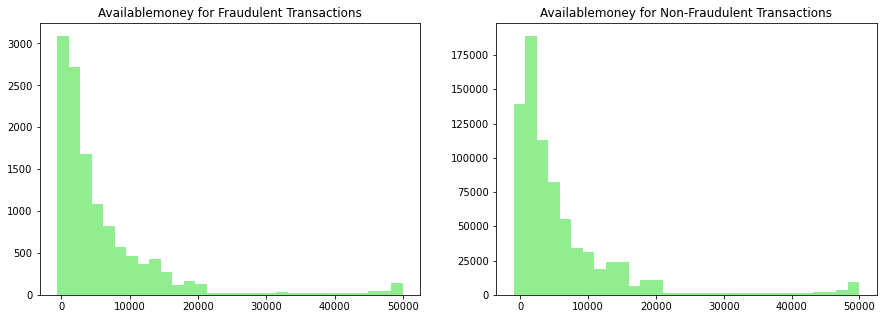

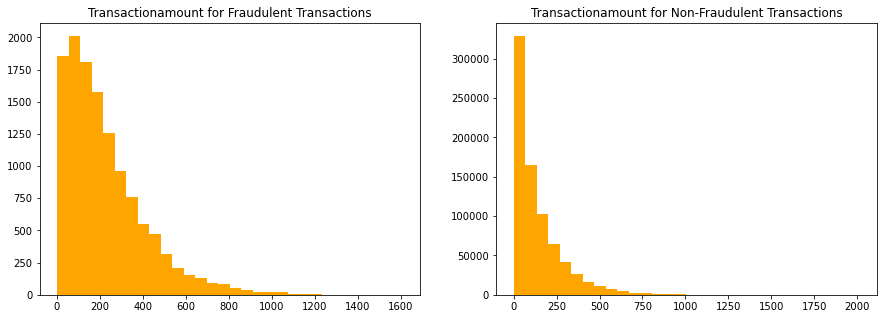

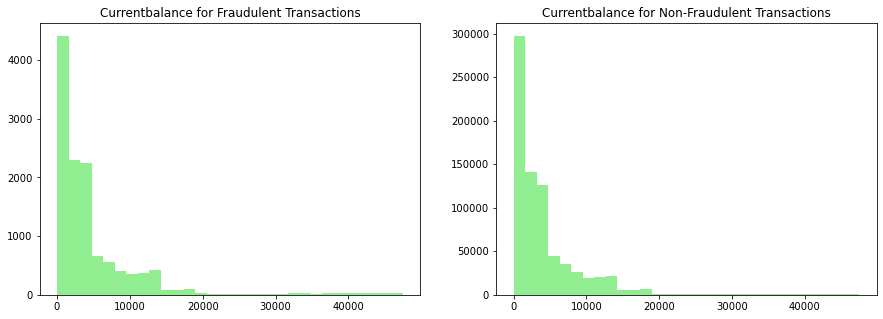

In [9]:
plt.rcParams['figure.figsize'] = (15,5)
numerical_cols = ['availableMoney', 'transactionAmount', 'currentBalance']
colors = ['lightgreen', 'orange']
for i,col in enumerate(numerical_cols):
    fig, ax = plt.subplots(ncols=2)
    
    ax[0].hist(main_df[main_df['isFraud']==True][col], bins=30, color=colors[i%2])
    ax[0].set_title(f'{col.capitalize()} for Fraudulent Transactions')
    
    ax[1].hist(main_df[main_df['isFraud']==False][col], bins=30, color=colors[i%2])
    ax[1].set_title(f'{col.capitalize()} for Non-Fraudulent Transactions')

    plt.show()

### There are just 12,417 cases of Fraud in our dataset of 786,363

In [10]:
count_frauds = main_df['isFraud'].value_counts()
print(f'The dataset contains {round(count_frauds[True]/count_frauds[False]*100,2)}% of fraudulent cases.')

The dataset contains 1.6% of fraudulent cases.


### Replace boolean-values with binary 0/1 instead
If True --> 1, otherwise 0.

In [11]:
boolean_columns = main_df.select_dtypes(include='bool').columns

for col in boolean_columns:
    main_df[col] = main_df[col].replace(True, 1).replace(False, 0)

### Convert categorical columns into one-hot-encodings

In [12]:
categorical_cols = set(main_df.select_dtypes(include='object').columns)
categorical_cols -= set(['transactionDateTime', 'accountOpenDate', 'dateOfLastAddressChange', 'currentExpDate'])
main_df[categorical_cols]

,merchantName,merchantCategoryCode,enteredCVV,transactionType,posEntryMode,acqCountry,merchantCountryCode,cardCVV,posConditionCode
0,Uber,rideshare,414,PURCHASE,02,US,US,414,01
1,AMC #191138,entertainment,486,PURCHASE,09,US,US,486,01
2,Play Store,mobileapps,486,PURCHASE,09,US,US,486,01
3,Play Store,mobileapps,486,PURCHASE,09,US,US,486,01
4,Tim Hortons #947751,fastfood,885,PURCHASE,02,US,US,885,01
...,...,...,...,...,...,...,...,...,...
786358,Lyft,rideshare,936,PURCHASE,90,US,US,936,01
786359,hulu.com,online_subscriptions,939,PURCHASE,09,US,US,939,01
786360,Lyft,rideshare,936,PURCHASE,02,US,US,936,01
786361,walmart.com,online_retail,939,PURCHASE,09,US,US,939,99


In [13]:
# Using label encoder rather than one-hot-encoding since even a 5-valued categorical feature requires 55GB!
label_encoder = LabelEncoder()
nvalues_categorical_df = main_df[categorical_cols].nunique()
cols_to_encode = list(nvalues_categorical_df.index[nvalues_categorical_df.values<=20])
for col in cols_to_encode[::-1]:
    print(f'Label-encoding {col} instead of OHE...')
    main_df[col] = label_encoder.fit_transform(main_df[col])

# Cleaning the 'Merchant name' column first to reduce 2,400 categories into 200 categories
get_clean_merchant_name = lambda name: re.sub(r' #.*', '', name).replace('.com', '')

main_df['merchantName'] = label_encoder.fit_transform(main_df['merchantName'].apply(get_clean_merchant_name))
main_df[categorical_cols]

Label-encoding posConditionCode instead of OHE...
Label-encoding merchantCountryCode instead of OHE...
Label-encoding acqCountry instead of OHE...
Label-encoding posEntryMode instead of OHE...
Label-encoding transactionType instead of OHE...
Label-encoding merchantCategoryCode instead of OHE...


,merchantName,merchantCategoryCode,enteredCVV,transactionType,posEntryMode,acqCountry,merchantCountryCode,cardCVV,posConditionCode
0,157,17,414,2,1,4,4,414,1
1,13,3,486,2,3,4,4,486,1
2,118,12,486,2,3,4,4,486,1
3,118,12,486,2,3,4,4,486,1
4,156,4,885,2,1,4,4,885,1
...,...,...,...,...,...,...,...,...,...
786358,94,17,936,2,5,4,4,936,1
786359,194,15,939,2,3,4,4,939,1
786360,94,17,936,2,1,4,4,936,1
786361,202,14,939,2,3,4,4,939,3


In [14]:
cols_to_drop = list(main_df.select_dtypes(exclude=['int64','float64','int32']).columns)
main_df = main_df.drop(cols_to_drop, axis=1)
main_df

,accountNumber,customerId,creditLimit,availableMoney,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,...,transactionDtMin,accountOpenDtYear,accountOpenDtMonth,accountOpenDtDay,accountOpenDtDayOfWeek,lastAddressChangeDtYear,lastAddressChangeDtMonth,lastAddressChangeDtDay,lastAddressChangeDtDayOfWeek,cvvMismatchScore
0,737265056,737265056,5000,5000.00,98.55,157,4,4,1,1,...,27,2015,3,14,5,2015,3,14,5,0.0
1,737265056,737265056,5000,5000.00,74.51,13,4,4,3,1,...,5,2015,3,14,5,2015,3,14,5,0.0
2,737265056,737265056,5000,5000.00,7.47,118,4,4,3,1,...,18,2015,3,14,5,2015,3,14,5,0.0
3,737265056,737265056,5000,5000.00,7.47,118,4,4,3,1,...,14,2015,3,14,5,2015,3,14,5,0.0
4,830329091,830329091,5000,5000.00,71.18,156,4,4,1,1,...,4,2015,8,6,3,2015,8,6,3,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786358,732852505,732852505,50000,48904.96,119.92,94,4,4,5,1,...,44,2012,8,23,3,2012,8,23,3,0.0
786359,732852505,732852505,50000,48785.04,18.89,194,4,4,3,1,...,20,2012,8,23,3,2012,8,23,3,0.0
786360,732852505,732852505,50000,48766.15,49.43,94,4,4,1,1,...,46,2012,8,23,3,2012,8,23,3,0.0
786361,732852505,732852505,50000,48716.72,49.89,202,4,4,3,3,...,30,2012,8,23,3,2012,8,23,3,0.0


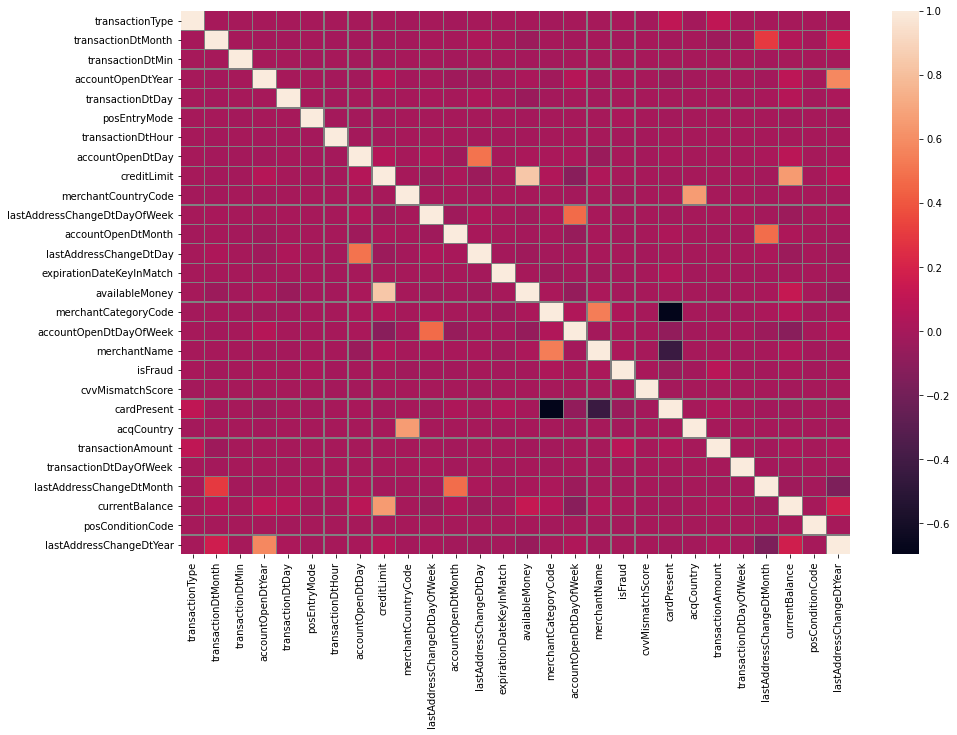

In [15]:
from seaborn import heatmap
import numpy as np

plt.rcParams['figure.figsize'] = (15,10)
columns_for_heatmap = set(main_df.columns) - set(['customerId', 'accountNumber', 'cardCVV', 'enteredCVV', 'cardLast4Digits'])
correlation_matrix = main_df[columns_for_heatmap].corr()
heatmap(correlation_matrix, xticklabels=correlation_matrix.columns, yticklabels=correlation_matrix.columns, 
        linewidths=0.25, linecolor='grey')
plt.show()

### There seems to be some Mutual-Information (correlation) between `cardPresent` and `merchantName`.

### Intuitively I even checked if there's any interaction between `cardPresent`, `merchantName`, and `isFraud`.

*Gut instinct might be right*: It seems that when card wasn't presented to the merchant, and CVV was a complete mismatch than expected, it was very likely a fraudulent transaction. (Refer to last-rows for `cardPresent=0` and `cardPresent=1` in below query)

In [16]:
main_df.groupby(by=['cardPresent','cvvMismatchScore']).agg({'cvvMismatchScore':'count', 'isFraud':'mean'})

cvvMismatchScore   isFraud
cardPresent cvvMismatchScore                            
0           0.000000                    429518  0.020509
            0.200000                       116  0.008621
            0.333333                      3461  0.038139
            0.500000                        16  0.062500
            0.666667                       237  0.037975
            1.000000                       147  0.068027
1           0.000000                    349830  0.009733
            0.200000                        79  0.000000
            0.333333                      2641  0.017418
            0.500000                        13  0.000000
            0.666667                       198  0.020202
            1.000000                       107  0.000000

In [17]:
from sklearn.preprocessing import StandardScaler
sc_creditLimit = StandardScaler().fit(main_df[['creditLimit']])
sc_availableMoney = StandardScaler().fit(main_df[['availableMoney']])
main_df['creditLimit'] = sc_creditLimit.transform(main_df[['creditLimit']])
main_df['availableMoney'] = sc_availableMoney.transform(main_df[['availableMoney']])

# Training models:

My intuition is- companies lose more loyal customers $\approx 33\%$ due to blocked transactions. An excellent article by Stripe [here](https://stripe.com/guides/primer-on-machine-learning-for-fraud-protection).

On the other hand, fraudulent transactions going unnoticed could lead to potential lawsuits, operational dispute fees, etc.

A subtle line needs to be drawn and my main focus here is to reduce blocked-transactions of legitimate customers: $Type$-$II$ error. 



We can design the Null and Alternative Hypothesis as "A transaction is legitimate until proven otherwise":

> $C_0$ : The transaction is legit.

> $C_1$ : The transaction is fraudulent.

$Type$-$II$ error would be a $False$ $Negative:$ expected $C_0$ but wrongly predicted $C_1$.

### Defining the Feature-set and Label-set to derive the train-test splits

In [18]:
flip_binary = lambda x: 1 if x==0 else 0
main_df['isFraud'] = main_df['isFraud'].apply(flip_binary)
main_df['isFraud'].value_counts()

1    773946
0     12417
Name: isFraud, dtype: int64

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, r2_score, accuracy_score, precision_score, recall_score

feature_cols = set(main_df.columns) - set(['isFraud', 'cardCVV', 'enteredCVV', 'cardLast4Digits', 'accountNumber', 'customerId'])
labels = main_df['isFraud']
features = main_df[feature_cols]
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, stratify=labels)

In [20]:
def print_neat_metrics(expected, preds, model_name='Logistic-Regression', show_confusion_matrix=False):
    print(f'Precision = {round(100*precision_score(expected, preds),2)}%.')
    print(f'Recall = {round(100*recall_score(expected, preds),2)}%.')
    print(f'Accuracy= {round(100*accuracy_score(expected, preds),2)}%.')
    if show_confusion_matrix:
        tn, fp, fn, tp = confusion_matrix(expected, preds).ravel()
        print(f'Confusion matrix for {model_name} model = \n\tTP={tp}  FN={fn}\n\tFP={fp}  TN={tn}\n')


In [21]:
from sklearn.linear_model import LogisticRegression

logistic_model = LogisticRegression(n_jobs=-1, verbose=1).fit(x_train, y_train)
preds = logistic_model.predict(x_test)

print_neat_metrics(y_test, preds, 'baseline Logistic-Regression', True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   31.8s finished


Precision = 98.42%.
Recall = 100.0%.
Accuracy= 98.42%.
Confusion matrix for baseline Logistic-Regression model = 
	TP=77395  FN=0
	FP=1242  TN=0



### Logistic regression just predicts the majority class. 🤔

### Let's look also at Decision Tree, since Logistic Regression is essentially useless here

In [22]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier().fit(x_train, y_train)
preds = decision_tree.predict(x_test)

print_neat_metrics(y_test, preds, 'baseline Decision-Tree', True)

Precision = 98.69%.
Recall = 98.26%.
Accuracy= 97.01%.
Confusion matrix for baseline Decision-Tree model = 
	TP=76052  FN=1343
	FP=1012  TN=230



In [23]:
from sklearn.model_selection import StratifiedKFold
strat_kfold_cv = StratifiedKFold(n_splits=10, shuffle=True)



for train_i, test_i in strat_kfold_cv.split(features, labels):
    x_train, x_test = features.iloc[train_i], features.iloc[test_i]
    y_train, y_test = labels.iloc[train_i], labels.iloc[test_i]
    decision_tree.fit(x_train, y_train)
    preds = decision_tree.predict(x_test)

    print_neat_metrics(y_test, preds, 'baseline Decision-Tree', True)

Precision = 98.7%.
Recall = 98.16%.
Accuracy= 96.91%.
Confusion matrix for baseline Decision-Tree model = 
	TP=75971  FN=1424
	FP=1004  TN=238

Precision = 98.66%.
Recall = 98.29%.
Accuracy= 97.01%.
Confusion matrix for baseline Decision-Tree model = 
	TP=76072  FN=1323
	FP=1030  TN=212

Precision = 98.68%.
Recall = 98.26%.
Accuracy= 96.99%.
Confusion matrix for baseline Decision-Tree model = 
	TP=76049  FN=1346
	FP=1021  TN=221

Precision = 98.7%.
Recall = 98.19%.
Accuracy= 96.94%.
Confusion matrix for baseline Decision-Tree model = 
	TP=75991  FN=1404
	FP=1004  TN=237

Precision = 98.66%.
Recall = 98.21%.
Accuracy= 96.92%.
Confusion matrix for baseline Decision-Tree model = 
	TP=76007  FN=1388
	FP=1032  TN=209

Precision = 98.66%.
Recall = 98.24%.
Accuracy= 96.95%.
Confusion matrix for baseline Decision-Tree model = 
	TP=76033  FN=1362
	FP=1033  TN=208

Precision = 98.64%.
Recall = 98.11%.
Accuracy= 96.81%.
Confusion matrix for baseline Decision-Tree model = 
	TP=75932  FN=1462
	FP=1

### Atleast now we get a practical prediction rather than just the majority class 🙂
On average baseline has a good $Recall$ ($True Positive Rate$) $\approx 98\%$, and equivalently a good $Precision$ $\approx 98\%$.

### Using a more complex Random-Forest model than baseline Logistic or Decision Tree
Isolation Forest is known to work well with highly-unbalanced sparse datasets (resembling Anomaly detection).

In [24]:
from sklearn.ensemble import IsolationForest, RandomForestClassifier

random_forest = RandomForestClassifier(n_jobs=-1)

for train_i, test_i in strat_kfold_cv.split(features, labels):
    x_train, x_test = features.iloc[train_i], features.iloc[test_i]
    y_train, y_test = labels.iloc[train_i], labels.iloc[test_i]
    random_forest.fit(x_train, y_train)
    preds = random_forest.predict(x_test)

    print_neat_metrics(y_test, preds, 'Random-Forest', True)

Precision = 98.54%.
Recall = 100.0%.
Accuracy= 98.54%.
Confusion matrix for Random-Forest model = 
	TP=77394  FN=1
	FP=1144  TN=98

Precision = 98.56%.
Recall = 100.0%.
Accuracy= 98.56%.
Confusion matrix for Random-Forest model = 
	TP=77395  FN=0
	FP=1130  TN=112

Precision = 98.6%.
Recall = 100.0%.
Accuracy= 98.6%.
Confusion matrix for Random-Forest model = 
	TP=77394  FN=1
	FP=1100  TN=142

Precision = 98.57%.
Recall = 100.0%.
Accuracy= 98.57%.
Confusion matrix for Random-Forest model = 
	TP=77395  FN=0
	FP=1124  TN=117

Precision = 98.57%.
Recall = 100.0%.
Accuracy= 98.57%.
Confusion matrix for Random-Forest model = 
	TP=77394  FN=1
	FP=1126  TN=115

Precision = 98.57%.
Recall = 100.0%.
Accuracy= 98.57%.
Confusion matrix for Random-Forest model = 
	TP=77394  FN=1
	FP=1124  TN=117

Precision = 98.56%.
Recall = 100.0%.
Accuracy= 98.56%.
Confusion matrix for Random-Forest model = 
	TP=77394  FN=0
	FP=1129  TN=113

Precision = 98.53%.
Recall = 100.0%.
Accuracy= 98.53%.
Confusion matrix 

In [25]:
iso_forest = IsolationForest(n_jobs=-1)

for train_i, test_i in strat_kfold_cv.split(features, labels):
    x_train, x_test = features.iloc[train_i], features.iloc[test_i]
    y_train, y_test = labels.iloc[train_i], labels.iloc[test_i]
    iso_forest.fit(x_train, y_train)
    preds = iso_forest.predict(x_test)
    preds = np.where(preds==-1, 0, preds)
    print_neat_metrics(y_test, preds, 'Isolation-Forest', True)

Precision = 98.49%.
Recall = 83.48%.
Accuracy= 82.48%.
Confusion matrix for Isolation-Forest model = 
	TP=64610  FN=12785
	FP=991  TN=251

Precision = 98.46%.
Recall = 80.98%.
Accuracy= 80.03%.
Confusion matrix for Isolation-Forest model = 
	TP=62671  FN=14724
	FP=978  TN=264

Precision = 98.48%.
Recall = 82.49%.
Accuracy= 81.51%.
Confusion matrix for Isolation-Forest model = 
	TP=63840  FN=13555
	FP=986  TN=256

Precision = 98.45%.
Recall = 84.88%.
Accuracy= 83.81%.
Confusion matrix for Isolation-Forest model = 
	TP=65695  FN=11700
	FP=1031  TN=210

Precision = 98.5%.
Recall = 84.17%.
Accuracy= 83.16%.
Confusion matrix for Isolation-Forest model = 
	TP=65142  FN=12253
	FP=993  TN=248

Precision = 98.48%.
Recall = 83.24%.
Accuracy= 82.24%.
Confusion matrix for Isolation-Forest model = 
	TP=64421  FN=12974
	FP=994  TN=247

Precision = 98.47%.
Recall = 83.82%.
Accuracy= 82.79%.
Confusion matrix for Isolation-Forest model = 
	TP=64870  FN=12524
	FP=1009  TN=233

Precision = 98.46%.
Recall

### Random Forest seems to perform better than the theoretically better Isolation Forest

Random-Forest gives an excellent $Recall$ $\approx 99.9\%$, and great $Precision$ $\approx 98\%$.

> Essentially, it will **very rarely** falsely accuse a legitimate-transaction as being fraudulent (Type-II error).

Seems like a good candidate for final predictions.

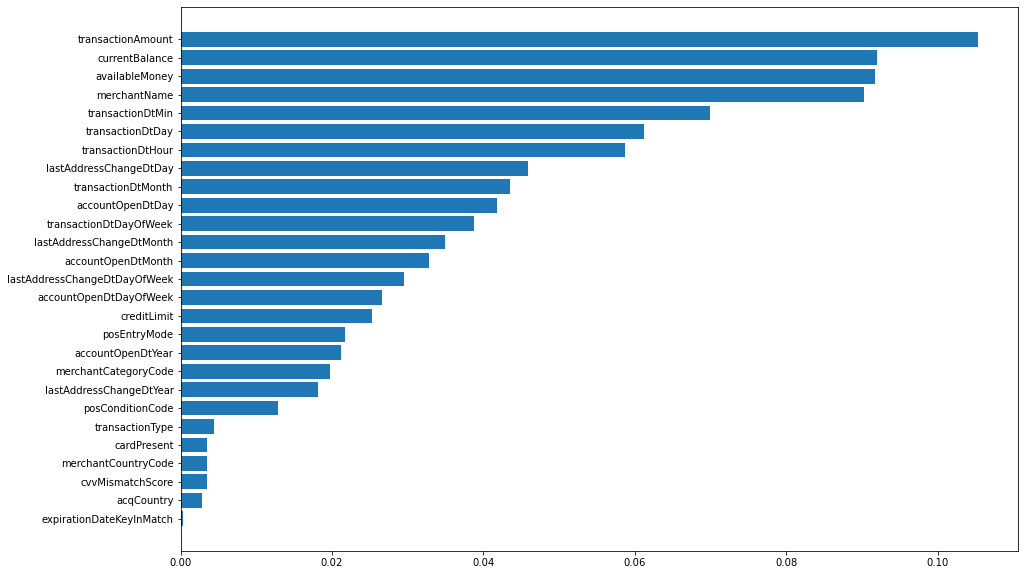

In [73]:
importances = pd.DataFrame(random_forest.feature_importances_)
importances.index = features.columns
importances = importances.sort_values(by=0)
fig, ax = plt.subplots()
ax.barh(importances.index, importances.to_numpy().flatten())
plt.show()